# Imports

In [197]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Functions

In [ ]:
def get_white_contour_points(img, csv_fname=''):
    data = {}
    white_pixels = np.argwhere(img == 255)

    for y, x in white_pixels:
        if x not in data:
            data[x] = [ y ]
        else:
            data[x] += [ y ]

    data_points = [ ( x, np.average(ys).astype(np.int64) ) for x, ys in data.items() ]

    if csv_fname != '':
        with open(csv_fname, 'w') as f:
            f.write('x,y\n')
            for x, y in sorted(data_points, key=lambda x: x[0]):
                f.write(f'{x},{y}\n')

    return np.resize(data_points, (len(data_points), 2))

# Baby graph extraction

In [198]:
img_fname = 'RCTG/pngs/RCTG/1/RCTG_1_1.png'

In [199]:
img = cv.imread(img_fname)

In [268]:
def imshow(image : np.ndarray, title='image', fx=0.25, fy=0.25, use_cv=False):
    if not use_cv:
        image_to_show = image.copy()
        if len(image.shape) == 2 or image.shape[2] == 1:
            image_to_show = cv.cvtColor(image_to_show, cv.COLOR_GRAY2RGB)
        else:
            image_to_show = cv.cvtColor(image_to_show, cv.COLOR_BGR2RGB)
        plt.title(title)
        plt.imshow(image_to_show)
    else:
        cv.imshow(title, cv.resize(image, (0, 0), fx=fx, fy=fy))
        cv.waitKey(0)
        cv.destroyAllWindows()

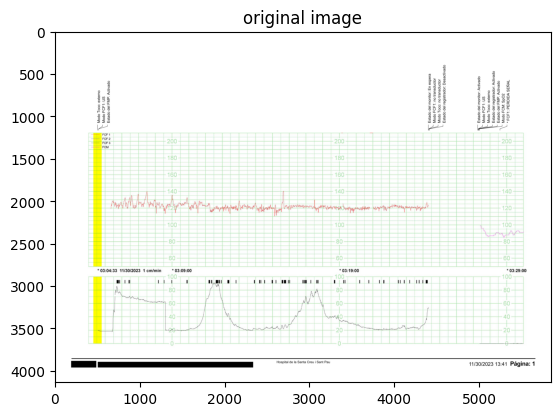

In [269]:
imshow(img, title='original image', fx=0.2, fy=0.2)

In [202]:
b, g, r = cv.split(img)

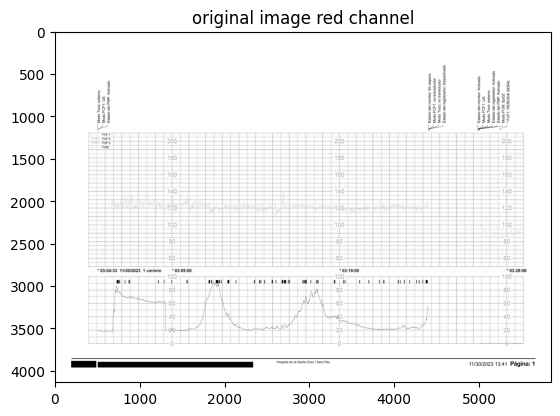

In [271]:
imshow(r, 'original image red channel')

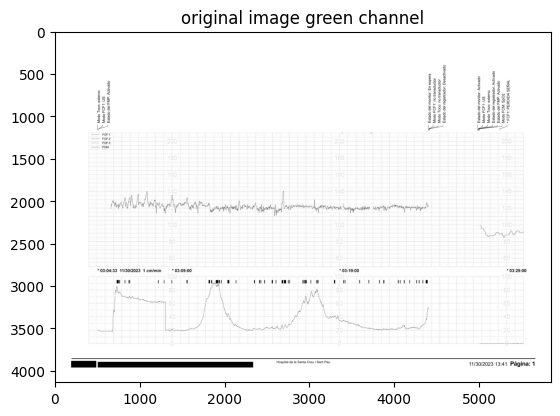

In [272]:
imshow(g, 'original image green channel')

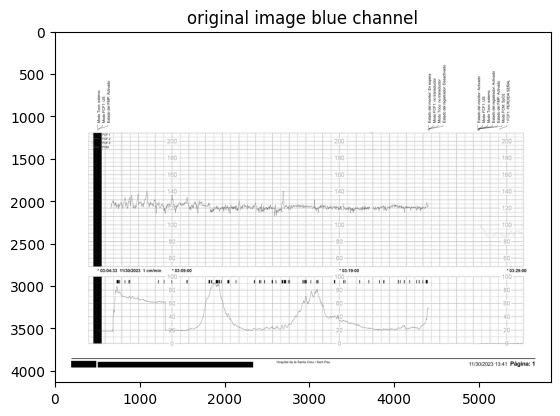

In [273]:
imshow(b, 'original image blue channel')

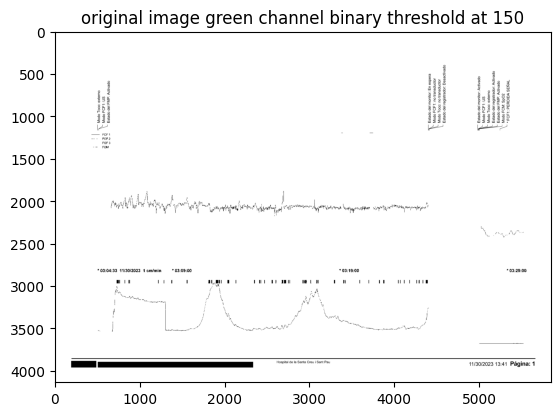

In [274]:
_, g_mask = cv.threshold(g, 150, 255, cv.THRESH_BINARY)
imshow(g_mask, 'original image green channel binary threshold at 150')

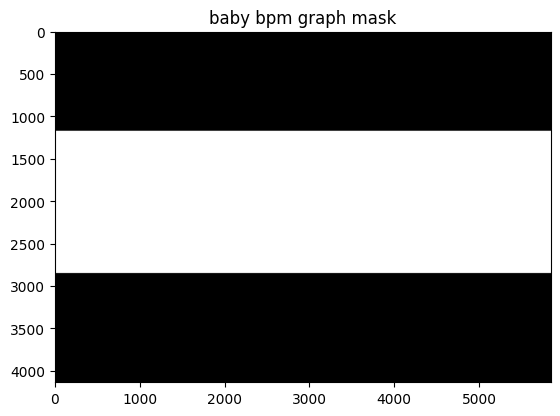

In [275]:
upper_graph_mask = np.uint8(np.zeros(img.shape[:2]))
start = 1175
end = start + 1675
cv.rectangle(upper_graph_mask, (0, start), (img.shape[1], end), 255, -1)
imshow(upper_graph_mask, 'baby bpm graph mask')

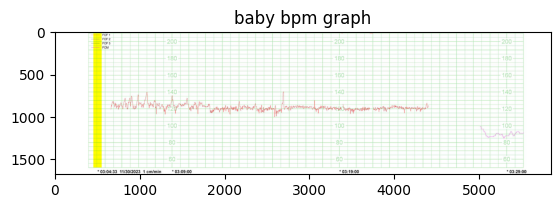

In [276]:
upper_graph = cv.bitwise_and(img, img, mask=upper_graph_mask)
upper_graph = upper_graph[start:end, 0:img.shape[1]]
imshow(upper_graph, 'baby bpm graph')

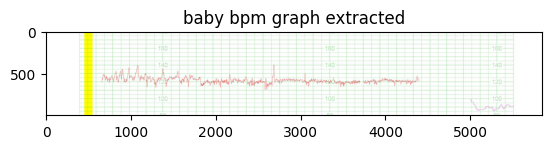

In [285]:
baby_graph_mask = np.uint8(np.zeros(upper_graph.shape[:2]))
start = 315
end = 1300
cv.rectangle(baby_graph_mask, (0, start), (img.shape[1], end), 255, -1)
baby_graph = cv.bitwise_and(upper_graph, upper_graph, mask=baby_graph_mask)
baby_graph = baby_graph[start:end, :]
imshow(baby_graph, 'baby bpm graph extracted')

In [284]:
baby_graph_b, baby_graph_g, baby_graph_r = cv.split(baby_graph)

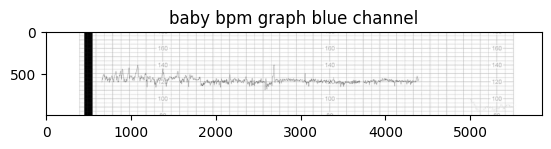

In [286]:
imshow(baby_graph_b, 'baby bpm graph blue channel')

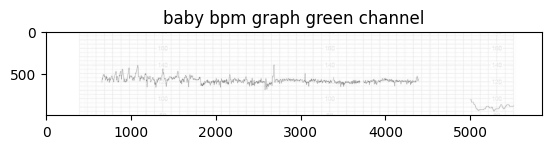

In [287]:
imshow(baby_graph_g, 'baby bpm graph green channel')

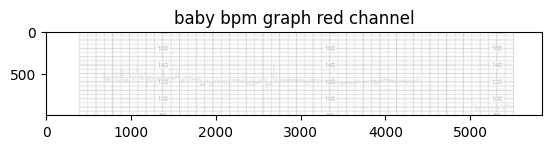

In [288]:
imshow(baby_graph_r, 'baby bpm graph red channel')

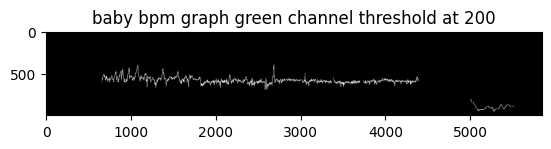

In [289]:
_, th_baby_graph_g = cv.threshold(baby_graph_g, 200, 255, cv.THRESH_BINARY_INV)
imshow(th_baby_graph_g, 'baby bpm graph green channel threshold at 200')

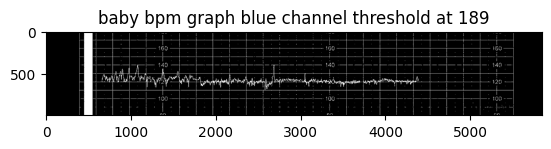

In [290]:
_, th_baby_graph_b = cv.threshold(baby_graph_b, 189, 255, cv.THRESH_BINARY_INV)
imshow(th_baby_graph_b, 'baby bpm graph blue channel threshold at 189')

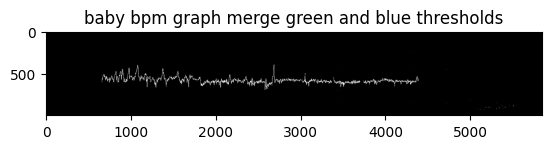

In [291]:
th_baby_graph = cv.bitwise_and(th_baby_graph_b, th_baby_graph_g)
imshow(th_baby_graph, 'baby bpm graph merge green and blue thresholds')

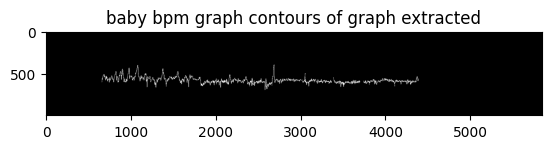

In [295]:
contours, _ = cv.findContours(th_baby_graph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = [ c for c in contours if cv.contourArea(c) >= 100 ]

baby_contour = np.uint8(np.zeros(th_baby_graph.shape))
cv.drawContours(baby_contour, contours, -1, 255, -1)
imshow(baby_contour, 'baby bpm graph contours of graph extracted')

In [296]:
baby_data_points = get_white_contour_points(baby_contour, 'holabebe.csv')

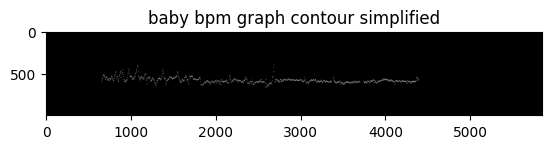

In [324]:
black = np.uint8(np.zeros(baby_contour.shape[:2]))
for x, y in baby_data_points:
    black[y, x] = 255
black = cv.dilate(black, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))
imshow(black, 'baby bpm graph contour simplified')

# Contracture extraction (me duele la espalda para los que no sepan ingles)

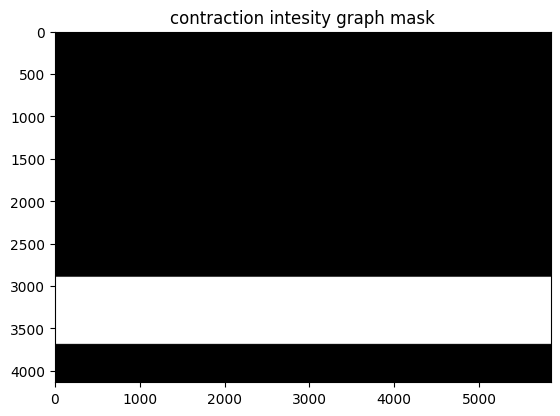

In [300]:
contraction_mask = np.uint8(np.zeros(img.shape[:2]))
contraction_graph_start = 2895
contraction_graph_end = 3685
cv.rectangle(contraction_mask, (0, contraction_graph_start), (img.shape[1], contraction_graph_end), 255, -1)
imshow(contraction_mask, fx=0.2, fy=0.2, title='contraction intesity graph mask')

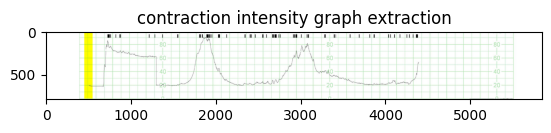

In [302]:
contraction_graph = cv.bitwise_and(img, img, mask=contraction_mask)
contraction_graph = contraction_graph[contraction_graph_start:contraction_graph_end, :]
imshow(contraction_graph, title='contraction intensity graph extraction')

In [303]:
contraction_graph_b, contraction_graph_g, contraction_graph_r = cv.split(contraction_graph)

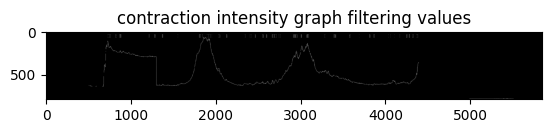

In [307]:
_, th_contraction_graph = cv.threshold(contraction_graph_g, 0, 255, cv.THRESH_OTSU)
th_contraction_graph = cv.bitwise_not(th_contraction_graph, th_contraction_graph)

contraction_graph_filtered = cv.bitwise_and(contraction_graph_g, contraction_graph_g, mask=th_contraction_graph)
imshow(contraction_graph_filtered, title='contraction intensity graph filtering values')

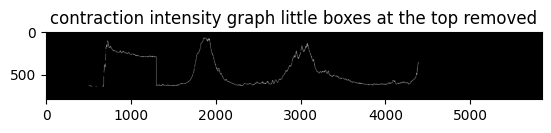

In [309]:
contraction_graph_mask = np.uint8(np.zeros(contraction_graph_filtered.shape))
cv.rectangle(contraction_graph_mask, (0, 80), (contraction_graph_mask.shape[1], 720), 255, -1)

contraction_graph_final = cv.bitwise_and(contraction_graph_filtered, contraction_graph_filtered, mask=contraction_graph_mask)
_, contraction_graph_final = cv.threshold(contraction_graph_final, 0, 255, cv.THRESH_BINARY)
imshow(contraction_graph_final, title='contraction intensity graph little boxes at the top removed')

In [310]:
contraction_data_points = get_white_contour_points(contraction_graph_final, 'contraction_points.csv')
contraction_data_points.shape

(3740, 2)

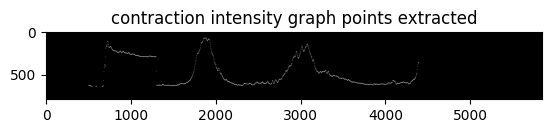

In [312]:
black = np.uint8(np.zeros(contraction_graph_final.shape[:2]))
for x, y in contraction_data_points:
    black[y, x] = 255

black = cv.dilate(black, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))
imshow(black, title='contraction intensity graph points extracted')

# Get contraction peaks

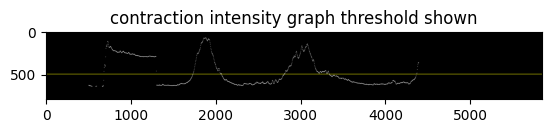

In [314]:
contraction_threshold = 500

contraction_graph_study = contraction_graph_final.copy()
contraction_graph_viz = np.uint8(np.zeros((*contraction_graph_final.shape[:2], 3)))
for x, y in contraction_data_points:
    contraction_graph_viz[y, x] = ( 255, 255, 255 )

cv.line(contraction_graph_viz, (0, contraction_threshold), (contraction_graph_viz.shape[1], contraction_threshold), (0, 255, 255))

contraction_graph_viz = cv.dilate(contraction_graph_viz, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))
imshow(contraction_graph_viz, title='contraction intensity graph threshold shown')

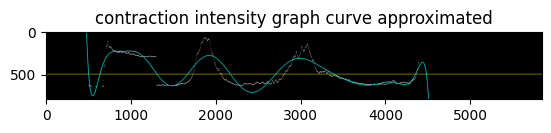

In [316]:
contraction_data_points_sorted = contraction_data_points[contraction_data_points[:, 0].argsort()]
x = contraction_data_points_sorted[:, 0]
y = contraction_data_points_sorted[:, 1]
z = np.polyfit(x, y, 15)
f = np.poly1d(z)

contraction_approx_curve = list(map(lambda x : (x, f(x)), list(range(contraction_graph_viz.shape[1]))))
contraction_approx_curve = np.resize(contraction_approx_curve, (len(contraction_approx_curve), 2))

contraction_graph_viz_cpy = contraction_graph_viz.copy()
for i in range(1, len(contraction_approx_curve)):   
    cv.line(contraction_graph_viz_cpy, contraction_approx_curve[i - 1].astype(np.int64), contraction_approx_curve[i].astype(np.int64), (255, 255, 0), 5)

imshow(contraction_graph_viz_cpy, title='contraction intensity graph curve approximated')

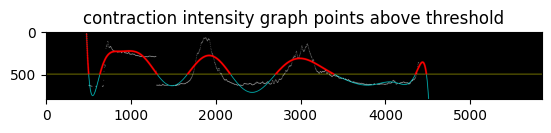

In [318]:
contraction_graph_viz_cpy_cpy = contraction_graph_viz_cpy.copy()

for idx in np.where(contraction_approx_curve[:, 1] < contraction_threshold)[0]:
    cv.circle(contraction_graph_viz_cpy_cpy, contraction_approx_curve[idx].astype(np.int64), 10, (0, 0, 255), -1)

imshow(contraction_graph_viz_cpy_cpy, title='contraction intensity graph points above threshold')

In [319]:
contraction_positions = []

contractions = np.where(contraction_approx_curve[:, 1] < contraction_threshold)[0]

contraction_positions = [ [ contractions[0], -1 ] ]
for i, idx in enumerate(contractions):
    if i == 0:
        continue


    if idx - contractions[i - 1] > 1:
        contraction_positions[-1][1] = contractions[i - 1]
        contraction_positions.append([ idx, -1 ])

if contraction_positions[-1][1] == -1:
    contraction_positions[-1][1] = contractions[-1]

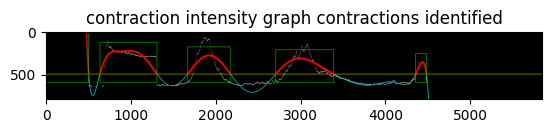

In [323]:
contraction_graph_viz_cpy_cpy_cpy = contraction_graph_viz_cpy_cpy.copy()
for ini_x, fin_x in contraction_positions:
    ini_y = np.min(contraction_approx_curve[ini_x:fin_x], axis=0)[1].astype(np.int64) - 100
    cv.rectangle(contraction_graph_viz_cpy_cpy, (ini_x, ini_y), (fin_x, contraction_threshold + 100), (0, 255, 0), 3)

imshow(contraction_graph_viz_cpy_cpy_cpy, title='contraction intensity graph contractions identified')